In [19]:
from offset_enum import OffsetValues as oe
from model import train_model, visualise
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd

In [38]:
# List all screenshots in screenshots directory 
screenshots = os.listdir('screenshots/')
images = list()

# Read screenshot in grayscale, crop points picture, apply thresholding to image
for screenshot in screenshots[0:50]:
    image = cv2.imread('screenshots/' + screenshot, cv2.IMREAD_GRAYSCALE)
    raw_1 = image[oe.competitor_1_points_upper_y:oe.competitor_1_points_lower_y,
            oe.competitor_1_points_left_x:oe.competitor_1_points_right_x]
    raw_2 = image[oe.competitor_2_points_upper_y:oe.competitor_2_points_lower_y,
            oe.competitor_2_points_left_x:oe.competitor_2_points_right_x]
    raw_1 = cv2.threshold(raw_1, 170, 255, cv2.THRESH_BINARY_INV)[1]
    raw_2 = cv2.threshold(raw_2, 170, 255, cv2.THRESH_BINARY)[1]
    images.extend([raw_1, raw_2])
    
# Resize to 28/28 pixels for model
images_resized = [cv2.resize(image, (28, 28), interpolation=cv2.INTER_LINEAR) for image in images]

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

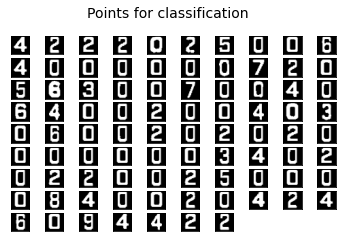

In [39]:
# Read in target labels 
df = pd.read_csv('csv_files/test_target.csv', index_col=0, na_values='None')

# Exclude erroneous images and double digits 
target = df.target[(df.target.notna()) & (df.target <= 10)]

# Convert to numpy & create binary array vector (class_labels * 1)
target = target.to_numpy()
target = keras.utils.to_categorical(target, 10)

# Convert list of images to (n, 28, 28, 1) shape for modelling
features = np.dstack(images_resized)
features = np.rollaxis(features, -1)
features = np.expand_dims(features, -1)

# Scale grayscale values 0-1 and remove erroneous images and double digits 
features = features.astype("float32") / 255
features = features[(df.target.notna()) & (df.target <= 10)]

# Visualise images
features_vis = np.split(features[:, :, :, 0], 87, axis=0)
features_vis = [i[0, :, :] for i in features_vis]
visualise(features_vis, main_title='Points for classification')

In [7]:
# Train CNN on MNIST & print accuracy
model = train_model()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________

Points classification accuracy: 0.99


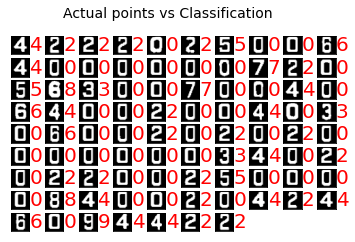

In [8]:
# Accuracy on scraped images
score = model.evaluate(features, target, verbose=0)
print(f'Points classification accuracy: {score[1]:0.2f}')

# Extract predictions
predictions = np.argmax(model.predict(features), axis=1)

# Visualise points against predictions 
for (i, image), prediction in zip(enumerate(features_vis), predictions):
    plt.suptitle('Actual points vs Classification', fontsize=14)
    plt.subplot(10, 10, i + 1)
    plt.imshow(image, 'gray')
    plt.text(28, 23, f'{prediction}', fontsize=20, color='red')
    plt.xticks([]), plt.yticks([])
plt.savefig('final_classification.png')